In [11]:
import math
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import json_normalize
from yaml import safe_load

sns.set_context("paper", font_scale=3)

LOG_DIR = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs/")


In [14]:
results_df = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    run_path = os.path.join(LOG_DIR, run_dir, "checkpoints/")

    results = glob.glob(run_path+"*.pickle")
    for result in results:
        df = pd.read_pickle(result)
        df = pd.DataFrame.from_records(df)
        df["dir_name"] = run_dir
        df["epoch"] = int(result.split("epoch=")[1].split("-")[0])
        results_df.append(df)


results_df = pd.concat(results_df, ignore_index=True)

# Remove superfluous NaN cells
def compress(values):
    for val in values:
        if val is not None and not np.isnan(val):
            return val

results_df = results_df.groupby(["dir_name", "epoch"]).aggregate(compress)
results_df.reset_index(inplace=True)
results_df

100%|██████████| 540/540 [03:41<00:00,  2.44it/s]


,dir_name,epoch,message_lengths/dataloader_idx_0,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,policy_loss/dataloader_idx_0,policy_length_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc_no_noise,...,policy_loss/dataloader_idx_1,policy_length_loss/dataloader_idx_1,message_lengths/dataloader_idx_2,receiver_loss/dataloader_idx_2,entropy_loss/dataloader_idx_2,policy_loss/dataloader_idx_2,policy_length_loss/dataloader_idx_2,receiver_message_lengths/dataloader_idx_0,receiver_message_lengths/dataloader_idx_1,receiver_message_lengths/dataloader_idx_2
0,version_1058286,2599,4.000000,0.014002,0.215065,-0.089586,0.0,1.000000,1.000000,1.000000,...,-0.472564,0.0,3.990339,0.002310,0.223594,-0.013691,0.0,NaN,NaN,NaN
1,version_1058287,3199,4.000000,0.055967,0.208567,-0.278934,0.0,0.869565,1.000000,1.000000,...,-0.248042,0.0,4.000000,0.001240,0.207243,-0.007485,0.0,NaN,NaN,NaN
2,version_1058288,3999,4.000000,0.309793,0.233748,-2.159579,0.0,0.652174,0.652174,0.652174,...,-3.194933,0.0,4.000000,0.001451,0.219853,-0.009459,0.0,NaN,NaN,NaN
3,version_1058289,3199,4.000000,0.050755,0.300532,-0.290637,0.0,0.956522,1.000000,1.000000,...,-0.570124,0.0,3.975845,0.001289,0.296562,-0.006829,0.0,1.934783,1.730769,1.816425
4,version_1058290,2599,4.000000,0.008154,0.243056,-0.056412,0.0,1.000000,1.000000,1.000000,...,-0.299365,0.0,4.000000,0.001511,0.240063,-0.010613,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,version_1061633,9899,9.000000,0.168138,1.936100,-4.430135,0.0,0.913043,0.913043,0.913043,...,-3.390712,0.0,8.961352,0.003318,1.947643,-0.092912,0.0,NaN,NaN,NaN
754,version_1061633,11899,9.000000,0.065500,1.943500,-1.886641,0.0,0.956522,1.000000,1.000000,...,-3.936256,0.0,9.000000,0.001494,1.933254,-0.039216,0.0,NaN,NaN,NaN
755,version_1061634,8299,9.000000,0.937875,1.971116,-28.092535,0.0,0.739130,0.739130,0.739130,...,-28.590614,0.0,9.000000,0.001502,1.931481,-0.040444,0.0,NaN,NaN,NaN
756,version_1061634,14199,9.000000,0.612656,1.936089,-17.579258,0.0,0.826087,0.869565,0.869565,...,-29.950298,0.0,9.000000,0.000502,1.937325,-0.014174,0.0,NaN,NaN,NaN


In [13]:
hp = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    file_path = os.path.join(LOG_DIR, run_dir, "hparams.yaml")
    file = safe_load(open(file_path))
    df = json_normalize(file)
    df["dir_name"] = run_dir
    hp.append(df)

hp = pd.concat(hp, ignore_index=True)
hp

100%|██████████| 540/540 [01:47<00:00,  5.04it/s]


In [18]:
def fix_duplicate_value(val, allow_offset=None):
    if isinstance(val, list):
        for el in val:
            if allow_offset is None:
                assert (el == val[0]) or (el == "None") or (val[0] == "None")
            else:
                assert (np.abs(el - val[0]) < allow_offset) or (el == "None") or (val[0] == "None")
        return val[0]
    else:
        return val

hp = hp.applymap(fix_duplicate_value)

In [19]:
# TODO:
# REFERENCE_METRIC = "val_acc_no_noise"
REFERENCE_METRIC = "val_acc"


indices_best_steps = results_df.groupby("dir_name")[REFERENCE_METRIC].idxmax()

df = results_df.loc[list(indices_best_steps)].copy()
df

,dir_name,epoch,message_lengths/dataloader_idx_0,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,policy_loss/dataloader_idx_0,policy_length_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc_no_noise,...,policy_loss/dataloader_idx_1,policy_length_loss/dataloader_idx_1,message_lengths/dataloader_idx_2,receiver_loss/dataloader_idx_2,entropy_loss/dataloader_idx_2,policy_loss/dataloader_idx_2,policy_length_loss/dataloader_idx_2,receiver_message_lengths/dataloader_idx_0,receiver_message_lengths/dataloader_idx_1,receiver_message_lengths/dataloader_idx_2
0,version_1058286,2599,4.000000,0.014002,0.215065,-0.089586,0.0,1.000000,1.000000,1.000000,...,-0.472564,0.0,3.990339,0.002310,0.223594,-0.013691,0.0,NaN,NaN,NaN
1,version_1058287,3199,4.000000,0.055967,0.208567,-0.278934,0.0,0.869565,1.000000,1.000000,...,-0.248042,0.0,4.000000,0.001240,0.207243,-0.007485,0.0,NaN,NaN,NaN
2,version_1058288,3999,4.000000,0.309793,0.233748,-2.159579,0.0,0.652174,0.652174,0.652174,...,-3.194933,0.0,4.000000,0.001451,0.219853,-0.009459,0.0,NaN,NaN,NaN
3,version_1058289,3199,4.000000,0.050755,0.300532,-0.290637,0.0,0.956522,1.000000,1.000000,...,-0.570124,0.0,3.975845,0.001289,0.296562,-0.006829,0.0,1.934783,1.730769,1.816425
4,version_1058290,2599,4.000000,0.008154,0.243056,-0.056412,0.0,1.000000,1.000000,1.000000,...,-0.299365,0.0,4.000000,0.001511,0.240063,-0.010613,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,version_1061631,9099,9.000000,0.164716,2.424278,-4.668422,0.0,0.913043,0.913043,0.913043,...,-4.621251,0.0,9.000000,0.001025,2.419120,-0.027591,0.0,2.630435,2.250000,2.241546
752,version_1061632,13499,9.000000,0.172790,1.992169,-5.424547,0.0,0.956522,0.956522,0.956522,...,-13.082906,0.0,9.000000,0.000525,1.974278,-0.015039,0.0,NaN,NaN,NaN
754,version_1061633,11899,9.000000,0.065500,1.943500,-1.886641,0.0,0.956522,1.000000,1.000000,...,-3.936256,0.0,9.000000,0.001494,1.933254,-0.039216,0.0,NaN,NaN,NaN
756,version_1061634,14199,9.000000,0.612656,1.936089,-17.579258,0.0,0.826087,0.869565,0.869565,...,-29.950298,0.0,9.000000,0.000502,1.937325,-0.014174,0.0,NaN,NaN,NaN


In [20]:
df.set_index("dir_name", inplace=True, drop=False)
if not hp.index.name == "dir_name":
    hp.set_index("dir_name", inplace=True, verify_integrity=True)
df = df.join(hp, how="left")

In [21]:
MAX_N_RUNS = 10
df.dropna(subset=["num_attributes", "num_values"], inplace=True)
df.fillna({"sender_layer_norm": 0, "receiver_layer_norm": 0}, inplace=True)

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]
df["layer_norm"] = df["sender_layer_norm"]

runs_best_entropy = []

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

num_agents_values = df["num_agents"].unique()
for num_agents in num_agents_values:
    print(f"\nNum agents: {num_agents}")

    for attr_val in attr_val_combinations:
        n_attributes = int(float(attr_val.split("_")[0]))
        n_values = int(float(attr_val.split("_")[1]))
        print(f"\n\t\tAttr: {n_attributes} Values: {n_values}")

        # length_cost_values = df["length_cost"].unique()
        length_cost_values = [0, 0.001]
        for length_cost in length_cost_values:
            for layer_norm in [0, 1]:
                max_len_values = df.max_len.unique()
                for max_len in max_len_values:
                    vocab_size_values = df.vocab_size.unique()
                    for vocab_size in vocab_size_values:
                        noise_values = df.noise.unique()
                        for noise in noise_values:
                            for feedback in (0, 1):
                                for self_repair in (0, 1):

                                    df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.feedback == feedback) & (df.num_agents == num_agents) & (df.noise == noise) & (df.self_repair == self_repair) & (df.max_len == max_len) & (df.vocab_size == vocab_size) & (df.layer_norm == layer_norm)]

                                    if len(df_config) == 0:
                                        continue

                                    print(f"\t\t\tLength cost: {length_cost}\t Noise: {noise}\tmax_len: {max_len}\t vocab_size: {vocab_size}\t layer_norm: {layer_norm}", end="")

                                    if feedback:
                                        print("\tFeedback", end="")
                                    elif self_repair:
                                        print("\tSelf repair", end="")
                                    else:
                                        print("\tBaseline", end="")

                                    print(f"\tFound {len(df_config)} runs") #: {df_config}

                                    avg_val_accs = df_config.groupby("sender_entropy_coeff").aggregate({REFERENCE_METRIC: "mean"})
                                    # Take the highest entropy coeff in case of tie
                                    best_entropy_coeff = avg_val_accs[avg_val_accs[REFERENCE_METRIC] == avg_val_accs.max()[0]].index[-1]

                                    df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff]
                                    print(f"\t\t\t\t\t\tbest entropy coeff: {best_entropy_coeff}; num runs: {len(df_best_entropy)}", end="")
                                    print(f"\tother: {avg_val_accs.to_dict()})", )

                                    if len(df_best_entropy) > MAX_N_RUNS:
                                        df_best_entropy = df_best_entropy.tail(10)
                                    runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)





Num agents: 1

		Attr: 4 Values: 4
			Length cost: 0	 Noise: 0.0	max_len: 5	 vocab_size: 100	 layer_norm: 0	Baseline	Found 25 runs
						best entropy coeff: 0.3; num runs: 10	other: {'val_acc': {0.1: 0.895652174949646, 0.3: 0.913043475151062, 0.5: 0.8130434811115265}})
			Length cost: 0	 Noise: 0.1	max_len: 5	 vocab_size: 100	 layer_norm: 0	Baseline	Found 25 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.860869562625885, 0.3: 0.8173913061618805, 0.5: 0.8173913061618805}})
			Length cost: 0	 Noise: 0.1	max_len: 5	 vocab_size: 100	 layer_norm: 0	Self repair	Found 25 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.808695650100708, 0.3: 0.778260862827301, 0.5: 0.7521739155054092}})
			Length cost: 0	 Noise: 0.1	max_len: 5	 vocab_size: 100	 layer_norm: 0	Feedback	Found 25 runs
						best entropy coeff: 0.1; num runs: 5	other: {'val_acc': {0.1: 0.834782600402832, 0.3: 0.7739130437374115, 0.5: 0.7086956471204757}})
			Length cost: 0	 Noi

In [22]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

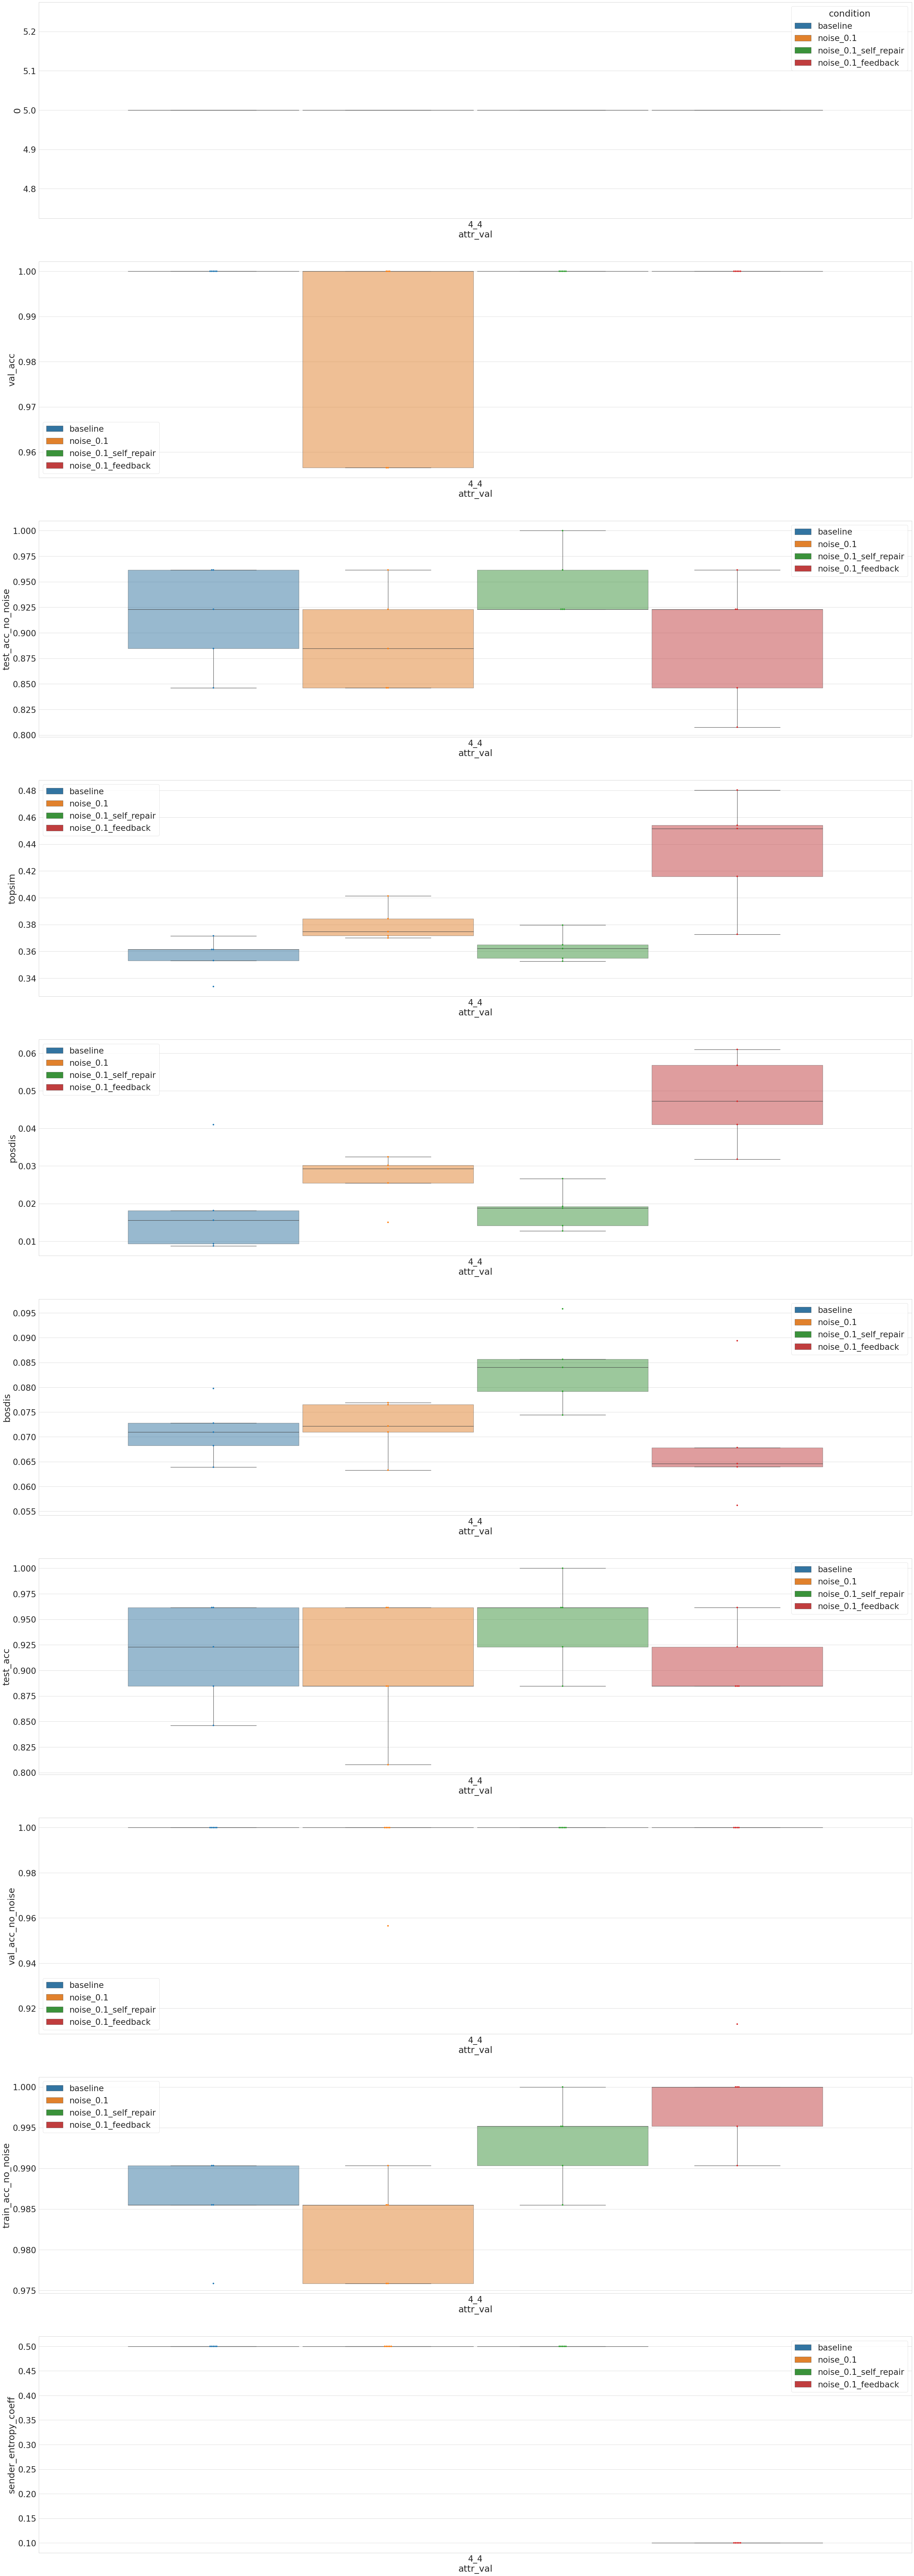

In [25]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["length_cost"].map(lambda x: f"_length_cost_{x}" if x > 0 else "") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["self_repair"].map(lambda x: "_self_repair" if x else "")

target_data = data.copy()

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 100
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]


# ATTR_VAL = "4_5"
# target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

# print(target_data.dir_name.unique())

# hue_order = None
# hue_order = ["baseline", "noise_0.1", "noise_0.1_feedback_binary"]
hue_order = ["baseline", "noise_0.1", "noise_0.1_self_repair", "noise_0.1_feedback"]

# order = ["2_10", "3_5", "2_16", "4_4", "4_5", "3_10", "2_100"]
order = ["4_4"]


target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()
# plt.figure(figsize=(30, 10))

_, axes = plt.subplots(10, 1, figsize=(50, 150))

sns.boxplot(ax=axes[0], data=num_runs_data, x="attr_val", order=order, hue="condition", hue_order=hue_order, y=0)

# next_axis_idx = (0, 0)
for i, metric in enumerate(["val_acc", "test_acc_no_noise", "topsim", "posdis", "bosdis", "test_acc", "val_acc_no_noise", "train_acc_no_noise", "sender_entropy_coeff"]):
    sns.boxplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, boxprops=dict(alpha=.5), showfliers = False)
    ax = sns.swarmplot(ax=axes[i+1], data=target_data, x=target_hparam, y=metric, order=order, hue="condition", hue_order=hue_order, dodge=True)
    handles, labels = ax.get_legend_handles_labels()
    num_conditions = int(len(handles)/2) if not hue_order else len(hue_order)
    ax.legend(handles[:num_conditions], labels[:num_conditions])
    # plt.setp(ax.get_legend().get_texts(), fontsize='22')
    # if next_axis_idx[1] >= axes.shape[1]-1:
    #     next_axis_idx = (next_axis_idx[0]+1, 0)
    # else:
    #     next_axis_idx = (next_axis_idx[0], next_axis_idx[1]+1)

name = "results"
plt.savefig("plots/"+name+".pdf", dpi=300)